In [2]:
#  Imports + Seed + Dataset Path Check  

from pathlib import Path
import os
import random
import numpy as np
import torch

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Dataset path  
DATASET_PATH = Path("/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage")

print("Dataset Path:", DATASET_PATH)

# Check path
if not DATASET_PATH.exists():
    raise FileNotFoundError(f"Dataset path not found: {DATASET_PATH}")

# Show folders inside dataset
folders = sorted([f.name for f in DATASET_PATH.iterdir() if f.is_dir()])
print(f"\nTotal class folders found: {len(folders)}")
print("Class folders:")
for f in folders:
    print(" -", f)


Dataset Path: /kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage

Total class folders found: 10
Class folders:
 - Tomato___Bacterial_spot
 - Tomato___Early_blight
 - Tomato___Late_blight
 - Tomato___Leaf_Mold
 - Tomato___Septoria_leaf_spot
 - Tomato___Spider_mites Two-spotted_spider_mite
 - Tomato___Target_Spot
 - Tomato___Tomato_Yellow_Leaf_Curl_Virus
 - Tomato___Tomato_mosaic_virus
 - Tomato___healthy


In [3]:
# Count images per class 

from pathlib import Path

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

class_counts = {}

for cls in sorted([d.name for d in DATASET_PATH.iterdir() if d.is_dir()]):
    cls_path = DATASET_PATH / cls
    imgs = [p for p in cls_path.iterdir() if p.suffix.lower() in IMG_EXTS]
    class_counts[cls] = len(imgs)

print("=== Class Image Counts ===\n")
for cls, cnt in class_counts.items():
    print(f"{cls:35s} → {cnt} images")

print("\nTotal Classes:", len(class_counts))
print("Total Images:", sum(class_counts.values()))


=== Class Image Counts ===

Tomato___Bacterial_spot             → 1702 images
Tomato___Early_blight               → 800 images
Tomato___Late_blight                → 1527 images
Tomato___Leaf_Mold                  → 761 images
Tomato___Septoria_leaf_spot         → 1417 images
Tomato___Spider_mites Two-spotted_spider_mite → 1341 images
Tomato___Target_Spot                → 1123 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus → 4286 images
Tomato___Tomato_mosaic_virus        → 299 images
Tomato___healthy                    → 1273 images

Total Classes: 10
Total Images: 14529


In [4]:
#    Split 70% / 15% / 15%

import pandas as pd
from sklearn.model_selection import train_test_split

# Collect all image paths + labels
image_paths = []
labels = []

for cls in sorted(class_counts.keys()):
    cls_path = DATASET_PATH / cls
    imgs = [p for p in cls_path.iterdir() if p.suffix.lower() in IMG_EXTS]
    for img in imgs:
        image_paths.append(str(img))
        labels.append(cls)

# DataFrame build
df = pd.DataFrame({
    "path": image_paths,
    "label": labels
})

print("Total images:", len(df))

# === Stratified split ===
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df["label"], random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df["label"], random_state=42
)

print("\nSplit Completed:")
print(" Train:", len(train_df))
print(" Val:  ", len(val_df))
print(" Test: ", len(test_df))

# Per-class check
print("\nTrain per-class:")
print(train_df["label"].value_counts().sort_index(), "\n")

print("Val per-class:")
print(val_df["label"].value_counts().sort_index(), "\n")

print("Test per-class:")
print(test_df["label"].value_counts().sort_index(), "\n")


Total images: 14529

Split Completed:
 Train: 10170
 Val:   2179
 Test:  2180

Train per-class:
label
Tomato___Bacterial_spot                          1191
Tomato___Early_blight                             560
Tomato___Late_blight                             1069
Tomato___Leaf_Mold                                533
Tomato___Septoria_leaf_spot                       992
Tomato___Spider_mites Two-spotted_spider_mite     939
Tomato___Target_Spot                              786
Tomato___Tomato_Yellow_Leaf_Curl_Virus           3000
Tomato___Tomato_mosaic_virus                      209
Tomato___healthy                                  891
Name: count, dtype: int64 

Val per-class:
label
Tomato___Bacterial_spot                          255
Tomato___Early_blight                            120
Tomato___Late_blight                             229
Tomato___Leaf_Mold                               114
Tomato___Septoria_leaf_spot                      212
Tomato___Spider_mites Two-spotted_spider_mit

DataLoader Ready!
Train: 10170 Val: 2179 Test: 2180
Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


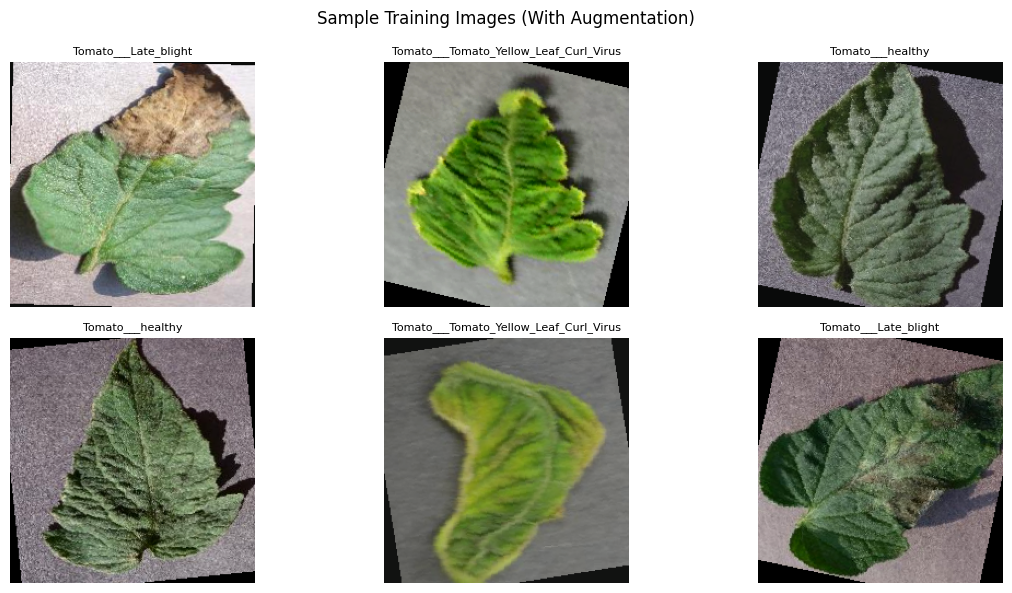

In [5]:
#  Dataset + DataLoader + Augmentation + Sample View

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Image size for DenseNet
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

# Class list
classes = sorted(df["label"].unique())
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

# ---- Dataset ----
class LeafDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "path"]
        label = class_to_idx[self.df.loc[idx, "label"]]

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, label, img_path

# ---- Transforms ----
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

# ---- Build datasets ----
train_dataset = LeafDataset(train_df, transform=train_tf)
val_dataset   = LeafDataset(val_df,   transform=val_tf)
test_dataset  = LeafDataset(test_df,  transform=val_tf)

# ---- DataLoaders ----
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

print("DataLoader Ready!")
print("Train:", len(train_dataset), "Val:", len(val_dataset), "Test:", len(test_dataset))
print("Classes:", classes)

# ---- Show Sample Batch ----
batch = next(iter(train_loader))
imgs, labels, paths = batch

def show_img(t):
    img = t.numpy().transpose(1,2,0)
    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img = np.clip(img, 0, 1)
    return img

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(show_img(imgs[i].cpu()))
    plt.title(idx_to_class[int(labels[i])], fontsize=8)
    plt.axis("off")

plt.suptitle("Sample Training Images (With Augmentation)", fontsize=12)
plt.tight_layout()
plt.show()


In [6]:
# DenseNet201 model setup  
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from pathlib import Path

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device ->", DEVICE)

# --- Load DenseNet201  ---
try:
  
    weights = models.DenseNet201_Weights.IMAGENET1K_V1
    model = models.densenet201(weights=weights)
except Exception:
    # older torchvision
    model = models.densenet201(pretrained=True)

# Replace classifier head for our number of classes
num_in = model.classifier.in_features
model.classifier = nn.Linear(num_in, len(classes))

model = model.to(DEVICE)

# --- Loss, optimizer, scheduler ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.3, patience=2
)

# --- Early stopping variables & checkpoint path ---
EARLY_STOPPING_PATIENCE = 6
best_val_loss = float("inf")
early_stop_counter = 0
best_model_path = Path("/kaggle/working/best_densenet201.pth") 

print("Model summary:")
print(" - DenseNet201 loaded")
print(f" - Output classes: {len(classes)}")
print("Optimizer: Adam (lr=1e-4)")
print("Scheduler: ReduceLROnPlateau (factor=0.3, patience=2)")
print("Early stopping patience:", EARLY_STOPPING_PATIENCE)
print("Best model will be saved to:", best_model_path)


Device -> cuda


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 173MB/s] 


Model summary:
 - DenseNet201 loaded
 - Output classes: 10
Optimizer: Adam (lr=1e-4)
Scheduler: ReduceLROnPlateau (factor=0.3, patience=2)
Early stopping patience: 6
Best model will be saved to: /kaggle/working/best_densenet201.pth


Training for up to 50 epochs...

Epoch 01/50 | Train Loss: 0.2747 Acc: 0.9259 || Val Loss: 0.0682 Acc: 0.9803 (171.3s)
  ✔ Validation improved — model saved.
Epoch 02/50 | Train Loss: 0.0607 Acc: 0.9840 || Val Loss: 0.0229 Acc: 0.9927 (170.7s)
  ✔ Validation improved — model saved.
Epoch 03/50 | Train Loss: 0.0385 Acc: 0.9894 || Val Loss: 0.0307 Acc: 0.9913 (170.8s)
  ✖ No improvement (1/6)
Epoch 04/50 | Train Loss: 0.0348 Acc: 0.9904 || Val Loss: 0.0221 Acc: 0.9936 (170.5s)
  ✔ Validation improved — model saved.
Epoch 05/50 | Train Loss: 0.0250 Acc: 0.9924 || Val Loss: 0.0147 Acc: 0.9959 (170.6s)
  ✔ Validation improved — model saved.
Epoch 06/50 | Train Loss: 0.0174 Acc: 0.9956 || Val Loss: 0.0312 Acc: 0.9885 (170.7s)
  ✖ No improvement (1/6)
Epoch 07/50 | Train Loss: 0.0245 Acc: 0.9929 || Val Loss: 0.0120 Acc: 0.9963 (170.6s)
  ✔ Validation improved — model saved.
Epoch 08/50 | Train Loss: 0.0138 Acc: 0.9961 || Val Loss: 0.0221 Acc: 0.9922 (170.6s)
  ✖ No improvement (1/6)
Epoch 09/

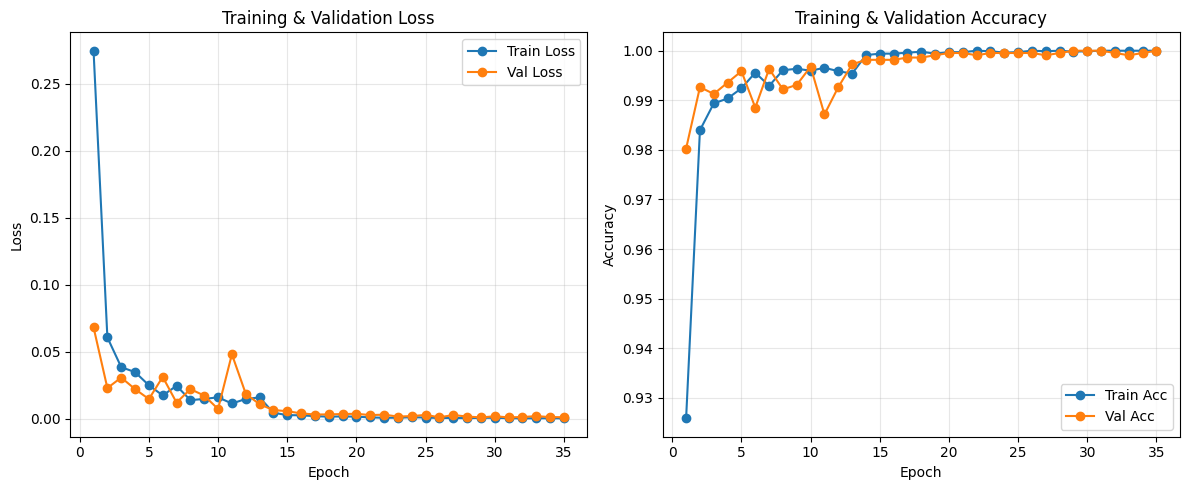


Best Validation Loss: 0.0009


In [7]:
# Training Loop  
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import copy

EPOCHS = 50
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

print(f"Training for up to {EPOCHS} epochs...\n")

best_weights = copy.deepcopy(model.state_dict())
start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_start = time.time()
  
    #       TRAIN PHASE      #
   
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for imgs, labels, _ in train_loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        train_loss += loss.item() * imgs.size(0)
        train_correct += torch.sum(preds == labels).item()
        total_train += imgs.size(0)

    train_loss /= total_train
    train_acc = train_correct / total_train

   
    #       VAL PHASE        #
   
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for imgs, labels, _ in val_loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * imgs.size(0)
            val_correct += torch.sum(preds == labels).item()
            total_val += imgs.size(0)

    val_loss /= total_val
    val_acc = val_correct / total_val

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    # Scheduler update
    scheduler.step(val_loss)

    # Print epoch summary
    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} || "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} "
          f"({time.time() - epoch_start:.1f}s)")

    # ---- Early Stopping ----
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        early_stop_counter = 0
        best_weights = copy.deepcopy(model.state_dict())
        torch.save(best_weights, best_model_path)
        print("  ✔ Validation improved — model saved.")
    else:
        early_stop_counter += 1
        print(f"  ✖ No improvement ({early_stop_counter}/{EARLY_STOPPING_PATIENCE})")

    if early_stop_counter >= EARLY_STOPPING_PATIENCE:
        print("\n⚠ Early stopping triggered!")
        break

# Load best weights after training
model.load_state_dict(best_weights)
total_time = (time.time() - start_time) / 60
print(f"\nTraining complete in {total_time:.2f} minutes.")
print(f"Best model loaded from: {best_model_path}")

 
#       PLOT GRAPHS         #
 

epochs_run = len(history["train_loss"])
x = np.arange(1, epochs_run + 1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(x, history["train_loss"], marker="o", label="Train Loss")
plt.plot(x, history["val_loss"], marker="o", label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.grid(alpha=0.3)
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(x, history["train_acc"], marker="o", label="Train Acc")
plt.plot(x, history["val_acc"], marker="o", label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nBest Validation Loss: {best_val_loss:.4f}")


=== Classification Report ===
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot     0.9961    0.9922    0.9941       256
                        Tomato___Early_blight     0.9917    1.0000    0.9959       120
                         Tomato___Late_blight     1.0000    0.9869    0.9934       229
                           Tomato___Leaf_Mold     0.9913    1.0000    0.9956       114
                  Tomato___Septoria_leaf_spot     1.0000    0.9953    0.9976       213
Tomato___Spider_mites Two-spotted_spider_mite     0.9901    1.0000    0.9950       201
                         Tomato___Target_Spot     0.9940    0.9881    0.9910       168
       Tomato___Tomato_Yellow_Leaf_Curl_Virus     0.9969    0.9984    0.9977       643
                 Tomato___Tomato_mosaic_virus     1.0000    1.0000    1.0000        45
                             Tomato___healthy     0.9948    1.0000    0.9974       191

           

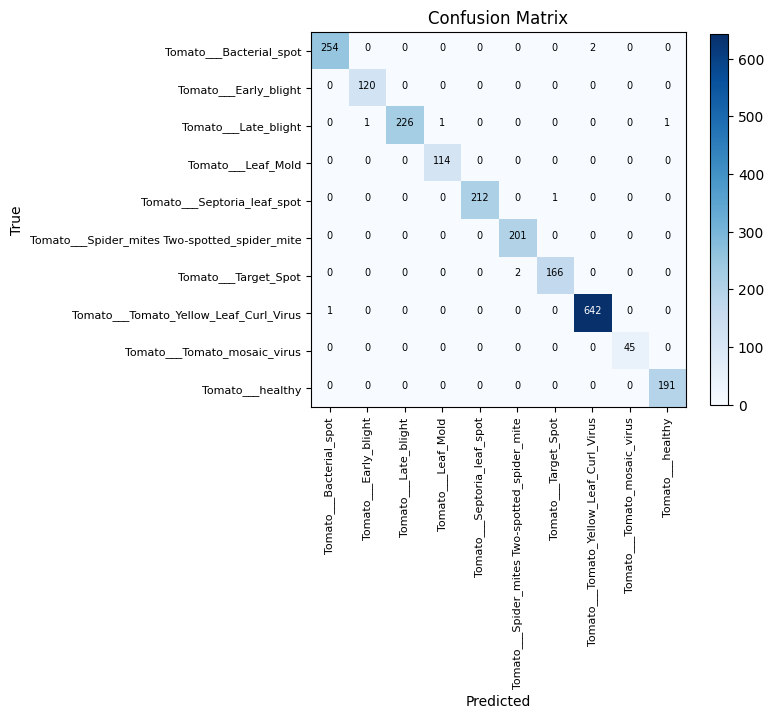

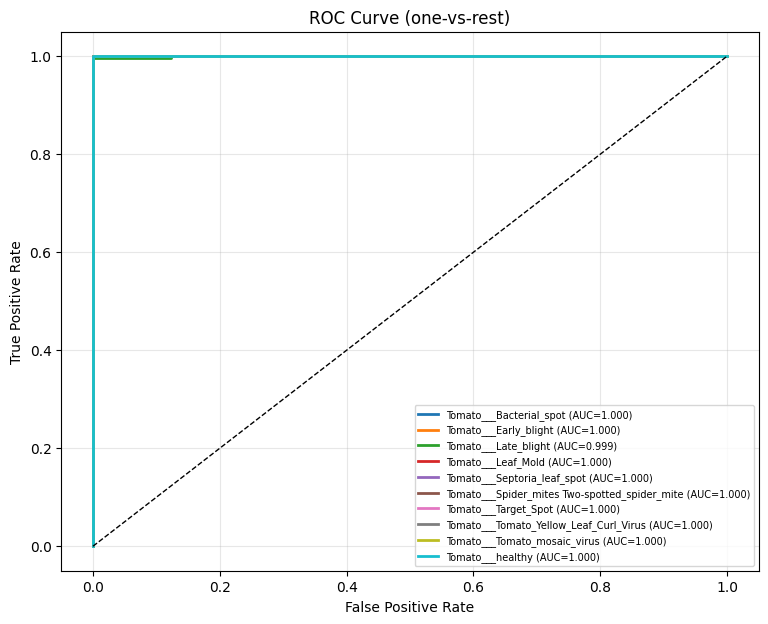

Misclassified samples: 9



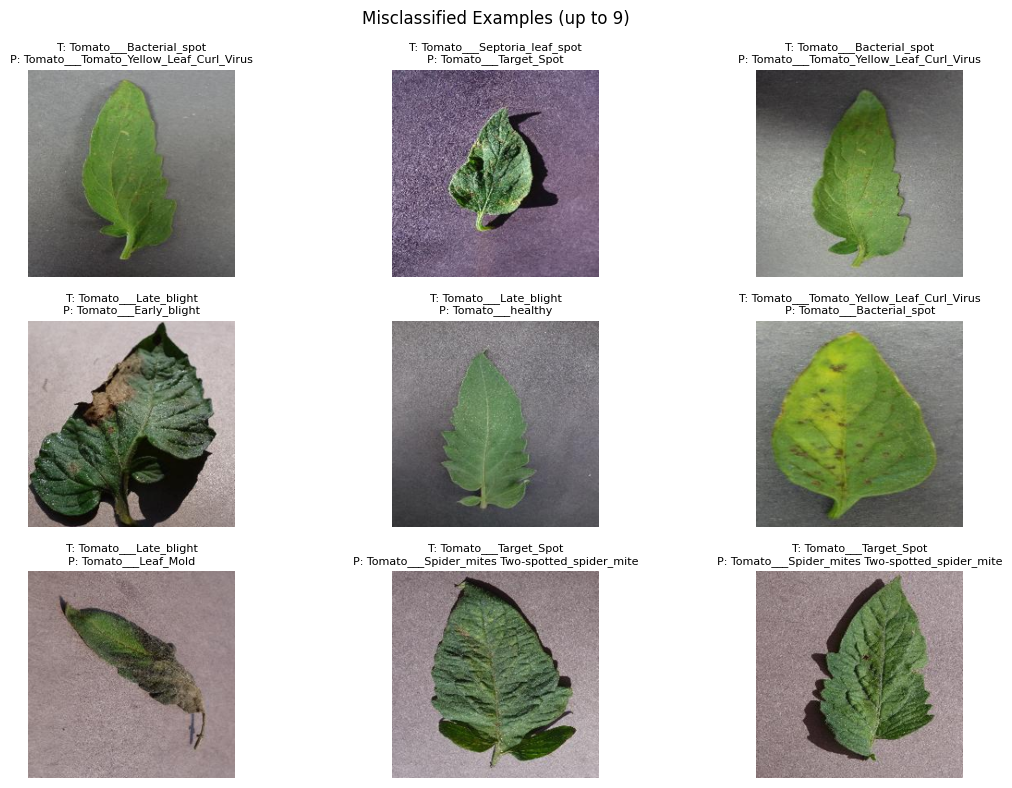

One-sample-per-class predictions (from test set):


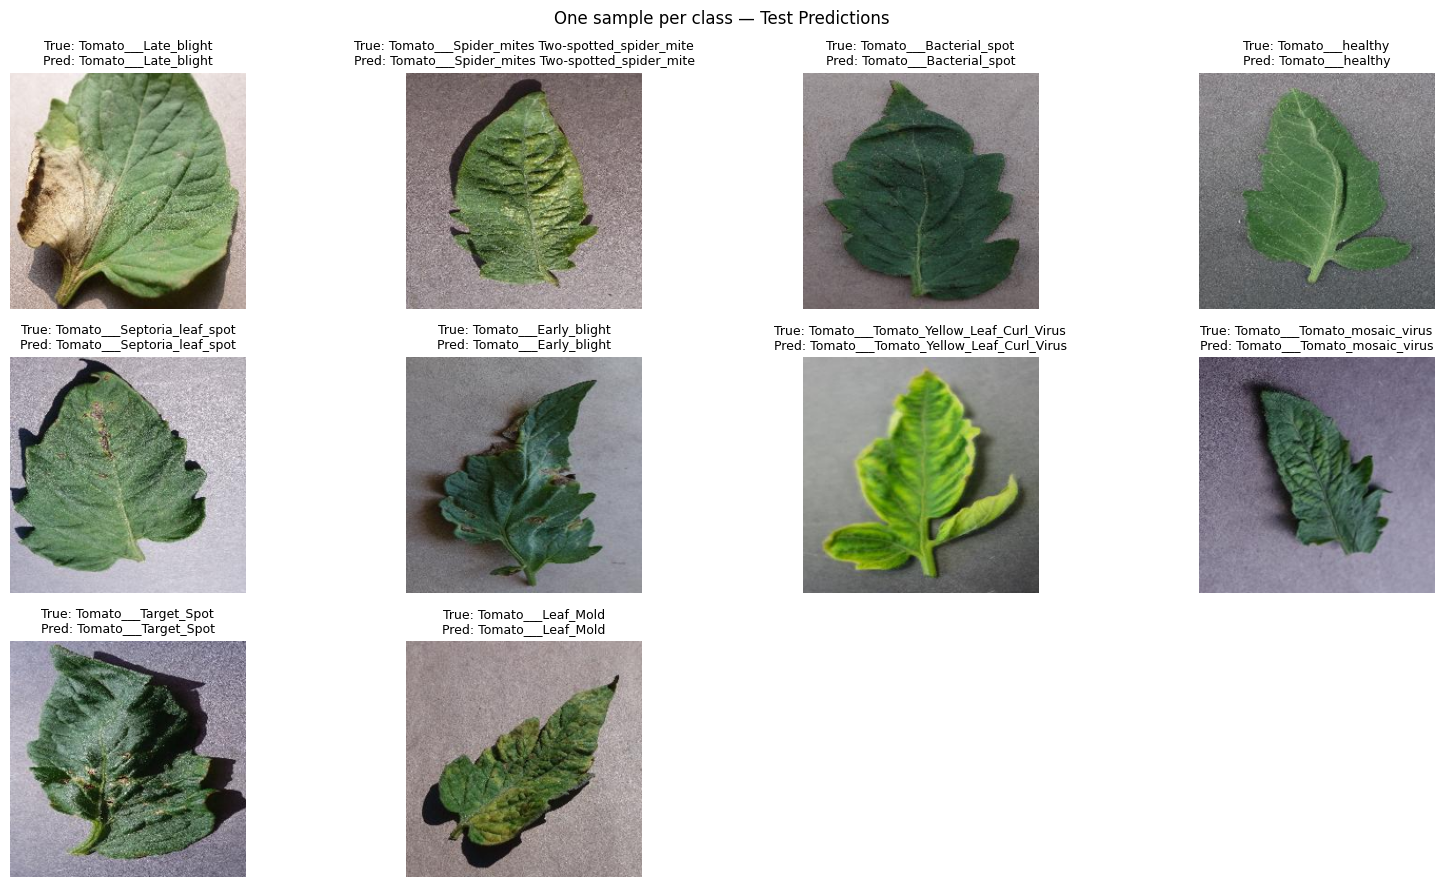

In [8]:
#  evaluation report, 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch
from PIL import Image

# Ensure model is in eval mode
model.eval()

# Collect predictions, labels, probs, paths
all_preds = []
all_labels = []
all_probs = []
all_paths = []

with torch.no_grad():
    for imgs, labels, paths in test_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        all_probs.append(probs)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.numpy().tolist())
        all_paths.extend(paths)

if len(all_labels) == 0:
    raise RuntimeError("No test samples found in test_loader.")

all_probs = np.vstack(all_probs)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# --- Classification report & Macro F1 ---
print("=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=classes, digits=4))
macro_f1 = f1_score(all_labels, all_preds, average="macro")
print(f"Macro F1 score: {macro_f1:.4f}\n")

# --- Confusion matrix (clean plot) ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar(shrink=0.7)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90, fontsize=8)
plt.yticks(tick_marks, classes, fontsize=8)
plt.xlabel("Predicted")
plt.ylabel("True")

# annotate counts
thresh = cm.max() / 2.0 if cm.size else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, int(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=7)

plt.tight_layout()
plt.show()

# --- ROC  
n_classes = len(classes)
can_plot_roc = True
 
if n_classes < 2:
    can_plot_roc = False
else:
    counts_per_class = np.bincount(all_labels, minlength=n_classes)
    if np.any(counts_per_class == 0):
        can_plot_roc = False

if can_plot_roc:
    y_bin = label_binarize(all_labels, classes=list(range(n_classes)))
    plt.figure(figsize=(9,7))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{classes[i]} (AUC={roc_auc:.3f})")
    plt.plot([0,1], [0,1], "k--", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (one-vs-rest)")
    plt.legend(loc="lower right", fontsize=7)
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("Skipping ROC plotting — need >=2 classes and at least one test sample per class.\n")

# --- Misclassified images  ---
mis_idx = np.where(all_preds != all_labels)[0]
n_mis = len(mis_idx)
print(f"Misclassified samples: {n_mis}\n")

if n_mis > 0:
    show_n = min(9, n_mis)
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(mis_idx[:show_n]):
        img_path = all_paths[idx]
        true_lbl = idx_to_class[int(all_labels[idx])]
        pred_lbl = idx_to_class[int(all_preds[idx])]
        img = Image.open(img_path).convert("RGB").resize((224,224))
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(f"T: {true_lbl}\nP: {pred_lbl}", fontsize=8)
        plt.axis("off")
    plt.suptitle("Misclassified Examples (up to 9)", fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified images — perfect on test set (rare!).\n")

 
print("One-sample-per-class predictions (from test set):")
picked = {}
for path, lbl, pred in zip(all_paths, all_labels, all_preds):
    cls_name = idx_to_class[int(lbl)]
    if cls_name not in picked:
        picked[cls_name] = (path, lbl, pred)

n_show = len(picked)
cols = min(4, n_show)
rows = int(np.ceil(n_show / cols))
plt.figure(figsize=(4*cols, 3*rows))
i = 1
for cls_name, (path, lbl, pred) in picked.items():
    img = Image.open(path).convert("RGB").resize((224,224))
    plt.subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(f"True: {idx_to_class[int(lbl)]}\nPred: {idx_to_class[int(pred)]}", fontsize=9)
    plt.axis("off")
    i += 1
plt.suptitle("One sample per class — Test Predictions", fontsize=12)
plt.tight_layout()
plt.show()
